# 1. Data Processing

In [93]:
#importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style= 'darkgrid' )

#some built in functions
import itertools
from datetime import datetime, timedelta

import warnings
#to supress warning generated for fb prophet using .append method by default
warnings.simplefilter(action='ignore', category=FutureWarning) 
#to suppress warnings in Sarima model
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)

#importing high level interactive plotting libraries
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

# importing time series stats model
import statsmodels.api as sm
from statsmodels.api import tsa 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#importing Sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX

#sklearn library
from sklearn.preprocessing import MinMaxScaler


#importing XG Boost 
import xgboost as xgb
from xgboost import plot_importance, plot_tree

#importing LSTM libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [94]:
timeseries_df = pd.read_csv('Data\\2010_present.csv')

In [95]:
timeseries_df['timestamp'] = pd.to_datetime(timeseries_df['timestamp'])
timeseries_df.set_index('timestamp', inplace=True)
#timeseries_df.index.freq = 'D' # To keep pandas inference in check!

In [96]:

#reading top five rows
print(timeseries_df.head())

# checking the mean, max and count values.
print(timeseries_df.describe())

            total_amount
timestamp               
2010-01-01     148173.71
2010-01-02     165787.50
2010-01-03     162360.15
2010-01-04     164382.94
2010-01-05     171372.72
        total_amount
count    3711.000000
mean   195767.979089
std     13915.936370
min      8364.030000
25%    187876.605000
50%    195909.510000
75%    203348.975000
max    278035.100000


In [97]:
timeseries_df

,total_amount
timestamp,
2010-01-01,148173.71
2010-01-02,165787.50
2010-01-03,162360.15
2010-01-04,164382.94
2010-01-05,171372.72
...,...
2020-02-24,239531.25
2020-02-25,260166.72
2020-02-26,244752.97


In [98]:
timeseries_df = timeseries_df.dropna()

In [99]:
# decomposing time series
#decomposition = tsa.seasonal_decompose(timeseries_df, model='additive')
decomposition = tsa.seasonal_decompose(timeseries_df, model='additive', period=365)  # Assuming yearly seasonality. Adjust if necessary.

In [100]:
#saving copy to new datafrme
present_df=timeseries_df.copy()

In [101]:
# add the decomposition data
present_df['Trend'] = decomposition.trend
present_df['Seasonal'] = decomposition.seasonal
present_df['Residual'] = decomposition.resid

In [102]:
#plotting the actual and decomposed componenets of time series
cols = ["total_amount","Trend", "Seasonal", "Residual"]

fig = make_subplots(rows=4, cols=1, subplot_titles=cols)

for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=present_df.index, y=present_df[col]),
        row=i+1,
        col=1
    )

fig.update_layout(height=1200, width=1200, showlegend=False)
fig.show()

## Check Stationery

In [103]:
def perform_adf_test(df) -> None:
    """
    Augmented Dickey Fuller Test
    - The null hypothesis for this test is that there is a unit root.
    - The alternate hypothesis is that there is no unit root in the series.
    ---
    Args:
        df (pd.DataFrame): Dataframe contains the timeseries data
        
    Returns: None
    """
    
    adf_stat, p_value, n_lags, n_observ, crit_vals, icbest = adfuller(df)
    
    print('\nAugmented Dickey Fuller Test')
    print('---'*15)
    print('ADF Statistic: %f' % adf_stat)
    print('p-value: %f' % p_value)
    print(f'Number of lags used: {n_lags}')
    print(f'Number of observations used: {n_observ}')
    print(f'T values corresponding to adfuller test:')
    for key, value in crit_vals.items():
        print(key, value)


def perform_kpss_test(df) -> None:
    """
    Kwiatkowski-Phillips-Schmidt-Shin test for stationary.
    - The null hypothesis for the test is that the data is stationary.
    - The alternate hypothesis for the test is that the data is not stationary.
    ---
    Args:
        df (pd.DataFrame): Dataframe that contains the timeseries data
        
    Returns: None
    """
    
    kpss_stat, p_value, n_lags, crit_vals = kpss(df, nlags='auto', store=False)
    print('\nKwiatkowski-Phillips-Schmidt-Shin test')
    print('---'*15)
    print('KPSS Statistic: %f' % kpss_stat)
    print('p-value: %f' % p_value)
    print(f'Number of lags used: {n_lags}')
    print(f'Critical values of KPSS test:')
    for key, value in crit_vals.items():
        print(key, value)

In [104]:
print("ADF and KPSS test on original total_amount")
print("******************************************")
perform_adf_test(present_df['total_amount'])
perform_kpss_test(present_df['total_amount'])

ADF and KPSS test on original total_amount
******************************************

Augmented Dickey Fuller Test
---------------------------------------------
ADF Statistic: -0.387827
p-value: 0.912111
Number of lags used: 29
Number of observations used: 3681
T values corresponding to adfuller test:
1% -3.432127741384456
5% -2.8623255075213123
10% -2.5671881372202803

Kwiatkowski-Phillips-Schmidt-Shin test
---------------------------------------------
KPSS Statistic: 7.116798
p-value: 0.010000
Number of lags used: 36
Critical values of KPSS test:
10% 0.347
5% 0.463
2.5% 0.574
1% 0.739


# 2. Presentation For Modeling

## 2.1 Train and Test Split

In [105]:
# Train - Test : 80 - 20
def train_test_split(df, train_end, test_set):
    train_set = df[df.index <= train_end]
    test_set = df[df.index > train_end]
    return train_set, test_set

train_end = '2018-01-01'
test_end = '2020-02-28'

train_df, test_df = train_test_split(timeseries_df, train_end, test_end)

In [106]:
print(f'The Train data has time range :Shape {train_df.shape} | {train_df.index[0]} to {train_df.index[-1]}')
print(f'The Test data has time range :Shape {test_df.shape} | {test_df.index[0]} to {test_df.index[-1]}' )

The Train data has time range :Shape (2923, 1) | 2010-01-01 00:00:00 to 2018-01-01 00:00:00
The Test data has time range :Shape (788, 1) | 2018-01-02 00:00:00 to 2020-02-28 00:00:00


## 2.2 Define function

In [107]:
def plot_forecast(train_set, test_set, forecast_series:pd.Series):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train_set.index, y=train_set, mode='lines', name='Train'))
    fig.add_trace(go.Scatter(x=test_set.index, y=test_set, mode='lines', name='Test'))
    fig.add_trace(go.Scatter(x=forecast_series.index, y=forecast_series, mode='lines', name='Forecast'))

    fig.update_xaxes(rangeslider_visible=True)
    fig.update_layout(yaxis_title='Total amount', xaxis_title='Date', title='Transactions amount and forecast')
    fig.show()

In [108]:
def plot_test_predictions(test_set, predictions) -> None:
    test_set = pd.Series(test_set, index=test_set.index)
    predictions = pd.Series(predictions, index=test_set.index)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=test_set.index, y=test_set.values, mode='lines', name='Test'))
    fig.add_trace(go.Scatter(x=predictions.index, y=predictions.values, mode='lines', name='Predictions'))

    fig.update_xaxes(rangeslider_visible=True)
    fig.update_layout(yaxis_title='Transactions amount for test and predicted values', xaxis_title='Date', title='Transactions amount')
    fig.show()

In [109]:
def mape(test_set, predicted) -> float:
    mape_result=round(np.mean(np.abs((test_set - predicted) / test_set)) * 100, 2)
    return mape_result

def rmse(test_set, predicted) -> float:
    rmse_result = round(np.sqrt(np.mean((test_set - predicted)**2)), 2)
    return rmse_result

# 3. XGBoost Modeling

## 3.1 Preparing for XGBoost
Đối với XGBoost, chúng tôi không thể cung cấp chuỗi thời gian như vậy, chúng tôi sẽ phải trích xuất các đặc điểm ngày giờ từ dấu thời gian đặt hàng của mình để tạo thành các biến độc lập nhằm dự đoán 'total_amount'.

In [110]:
#function to extract features from date
def create_features(dataframe, label=None):
    df=dataframe.copy()
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)
    X = df[['dayofweek', 'quarter', 'month', 'year', 'dayofyear','dayofmonth', 'weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [111]:
#creating dataframe with only required columns
data_xgb=timeseries_df[['total_amount']]

In [112]:
#Separating X and y 
X, y= create_features(data_xgb, label='total_amount')

In [113]:
X.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
timestamp,,,,,,,
2010-01-01,4,1,1,2010,1,1,53
2010-01-02,5,1,1,2010,2,2,53
2010-01-03,6,1,1,2010,3,3,53
2010-01-04,0,1,1,2010,4,4,1
2010-01-05,1,1,1,2010,5,5,1


In [114]:
#splitting the data for train andt test
train_end = '2018-01-01'
test_end = '2020-02-28'

X_train, X_test = train_test_split(X, train_end, test_end)
y_train, y_test = train_test_split(y, train_end, test_end)

## 3.2 Baseline Model

In [115]:
#instantiate the XGBoost Model
reg = xgb.XGBRegressor(n_estimators=1000, max_depth=3)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True)

[0]	validation_0-rmse:11499.85986	validation_1-rmse:16748.54406
[1]	validation_0-rmse:10699.20257	validation_1-rmse:15793.90776
[2]	validation_0-rmse:10182.64685	validation_1-rmse:15456.32335
[3]	validation_0-rmse:9903.33320	validation_1-rmse:15266.99774
[4]	validation_0-rmse:9720.43104	validation_1-rmse:15154.91093
[5]	validation_0-rmse:9440.12266	validation_1-rmse:14997.26451
[6]	validation_0-rmse:9273.48809	validation_1-rmse:15050.57442
[7]	validation_0-rmse:9192.19812	validation_1-rmse:14901.13971
[8]	validation_0-rmse:9128.48441	validation_1-rmse:14884.65923
[9]	validation_0-rmse:9068.50432	validation_1-rmse:14828.02204
[10]	validation_0-rmse:8952.50648	validation_1-rmse:14835.08880
[11]	validation_0-rmse:8922.40317	validation_1-rmse:14850.64622
[12]	validation_0-rmse:8877.48005	validation_1-rmse:14850.75353
[13]	validation_0-rmse:8838.26923	validation_1-rmse:14840.87136
[14]	validation_0-rmse:8760.49468	validation_1-rmse:14910.21509
[15]	validation_0-rmse:8738.19636	validation_1-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

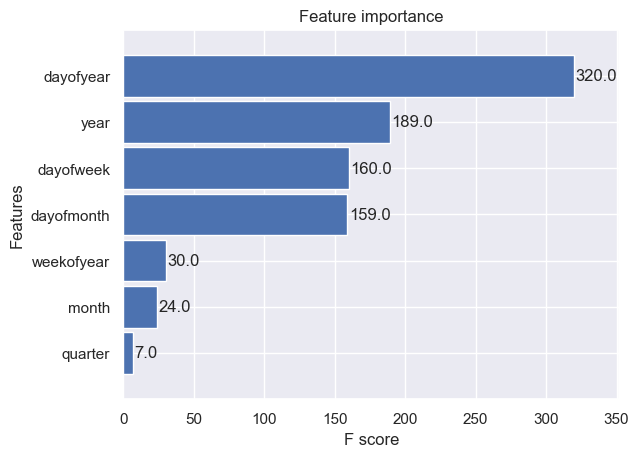

In [116]:
#plot feature importance
plot_importance(reg, height=0.9)

In [117]:
#evaluating on test set
predictions_xgb = reg.predict(X_test)
#calculating MAPE and RMSE
mape_xgb=mape(y_test, predictions_xgb )
rmse_xgb=rmse(y_test, predictions_xgb )

print(f'Root Mean Squared Error | RMSE: {rmse_xgb}')
print(f'Mean Absolute Percentage Error | MAPE: {mape_xgb}')

Root Mean Squared Error | RMSE: 14395.77
Mean Absolute Percentage Error | MAPE: 4.78


In [118]:
#evaluating on test set
predictions_xgb

array([204909.58, 204559.53, 206079.42, 201340.69, 208620.23, 204936.05,
       195975.73, 198032.19, 202031.4 , 206755.19, 202294.95, 208368.1 ,
       208294.66, 191478.62, 195283.36, 190585.23, 206265.12, 203899.06,
       209785.69, 208569.55, 194489.62, 199825.36, 202790.47, 206825.73,
       203563.16, 209619.55, 209892.89, 181556.02, 194406.16, 197857.95,
       206795.19, 205409.52, 211009.05, 206930.48, 196128.12, 203322.42,
       204868.34, 208903.61, 204897.7 , 210970.84, 207599.78, 196094.61,
       202570.12, 204792.08, 206339.75, 203077.17, 207817.45, 207524.31,
       195937.62, 193101.19, 191087.03, 206652.53, 204363.75, 210832.12,
       211618.08, 194477.28, 197432.67, 200957.36, 205494.38, 204108.7 ,
       210289.98, 208210.94, 194272.73, 201467.03, 202886.3 , 206199.36,
       202193.45, 208848.34, 205477.28, 195327.2 , 201802.72, 204176.23,
       202858.56, 199595.98, 205210.73, 203091.25, 193215.97, 199691.48,
       201874.1 , 205187.16, 201777.44, 208245.81, 

In [119]:
start_date = datetime(2019, 8, 31)
end_date = start_date + pd.DateOffset(days=365)
full_range = pd.date_range(start=start_date, end=end_date, freq='D')
forecast_df = pd.DataFrame(index=full_range)


# make forecast
X_forecast = create_features(forecast_df)
#X_forecast['is_holiday'] = forecast_df['is_holiday']

xgboost_forecast = reg.predict(X_forecast)

# create df for all y values
y_train_df = pd.DataFrame(y_train, train_df.index, columns=['total_amount'] )
y_test_df = pd.DataFrame(y_test, test_df.index, columns=['total_amount'] )
xgboost_forecast_df=pd.DataFrame(xgboost_forecast, forecast_df.index, columns=['Forecast'] )

In [120]:
plot_test_predictions(y_test_df['total_amount'], predictions_xgb)

In [121]:
#plotting forecast
plot_forecast(y_train_df['total_amount'], y_test_df['total_amount'], xgboost_forecast_df['Forecast'] )

## 3.3 Tunning XGBoost

In [122]:
num_estimators= [i for i in range(100, 1100, 100)]
depth=[i for i in range(3, 15, 1)]
learning=[0.0001, 0.001, 0.01, 0.1, 0.2]

In [123]:
'''XGB_summary=pd.DataFrame(columns=['n_estimators', 'max_depth', 'learning_rate', 'MAPE', 'RMSE' ])

for i in num_estimators:
    for j in depth:
        for k in learning:
            model_reg= xgb.XGBRegressor(n_estimators=i, max_depth=j, learning_rate=k )
            model_reg.fit(X_train, y_train)
            predictions_xgb = model_reg.predict(X_test)
            mape_xgb=np.mean(np.abs((y_test - predictions_xgb)/y_test))*100
            rmse_xgb = np.sqrt(np.mean((y_test-predictions_xgb)**2))
            data_param={'n_estimators': i,
                        'max_depth': j,
                        'learning_rate': k,
                        'MAPE': mape_xgb,
                        'RMSE' : rmse_xgb }
            XGB_summary=pd.concat([XGB_summary, pd.DataFrame(data_param, columns=XGB_summary.columns, index=[1])], ignore_index=True)
'''

"XGB_summary=pd.DataFrame(columns=['n_estimators', 'max_depth', 'learning_rate', 'MAPE', 'RMSE' ])\n\nfor i in num_estimators:\n    for j in depth:\n        for k in learning:\n            model_reg= xgb.XGBRegressor(n_estimators=i, max_depth=j, learning_rate=k )\n            model_reg.fit(X_train, y_train)\n            predictions_xgb = model_reg.predict(X_test)\n            mape_xgb=np.mean(np.abs((y_test - predictions_xgb)/y_test))*100\n            rmse_xgb = np.sqrt(np.mean((y_test-predictions_xgb)**2))\n            data_param={'n_estimators': i,\n                        'max_depth': j,\n                        'learning_rate': k,\n                        'MAPE': mape_xgb,\n                        'RMSE' : rmse_xgb }\n            XGB_summary=pd.concat([XGB_summary, pd.DataFrame(data_param, columns=XGB_summary.columns, index=[1])], ignore_index=True)\n"

In [124]:
#XGB_summary.sort_values(by ='MAPE', ascending=True)

In [125]:
#instantiate the XGBoost Model
reg_tuned = xgb.XGBRegressor(n_estimators=700, max_depth=3, learning_rate=0.01)
reg_tuned.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True)

[0]	validation_0-rmse:12860.92788	validation_1-rmse:17818.43958
[1]	validation_0-rmse:12809.56231	validation_1-rmse:17778.90623
[2]	validation_0-rmse:12759.01324	validation_1-rmse:17739.96423
[3]	validation_0-rmse:12709.26904	validation_1-rmse:17701.60384
[4]	validation_0-rmse:12660.32183	validation_1-rmse:17663.81832
[5]	validation_0-rmse:12612.16009	validation_1-rmse:17626.60308
[6]	validation_0-rmse:12564.76981	validation_1-rmse:17589.94637
[7]	validation_0-rmse:12518.12745	validation_1-rmse:17553.83444
[8]	validation_0-rmse:12472.23324	validation_1-rmse:17518.26507
[9]	validation_0-rmse:12427.07070	validation_1-rmse:17483.23171
[10]	validation_0-rmse:12382.63722	validation_1-rmse:17448.72301
[11]	validation_0-rmse:12338.91484	validation_1-rmse:17414.73691
[12]	validation_0-rmse:12295.90201	validation_1-rmse:17381.25997
[13]	validation_0-rmse:12253.58087	validation_1-rmse:17348.28582
[14]	validation_0-rmse:12211.95268	validation_1-rmse:17315.81258
[15]	validation_0-rmse:12170.99644	

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [126]:
# #evaluating on test set
predictions_xgb_tuned = reg_tuned.predict(X_test)
#calculating MAPE and RMSE
mape_xgb_tuned=mape(y_test, predictions_xgb_tuned )
rmse_xgb_tuned=rmse(y_test, predictions_xgb_tuned )

print(f'Root Mean Squared Error | RMSE: {rmse_xgb_tuned}')
print(f'Mean Absolute Percentage Error | MAPE: {mape_xgb_tuned}')

Root Mean Squared Error | RMSE: 14556.26
Mean Absolute Percentage Error | MAPE: 4.59


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

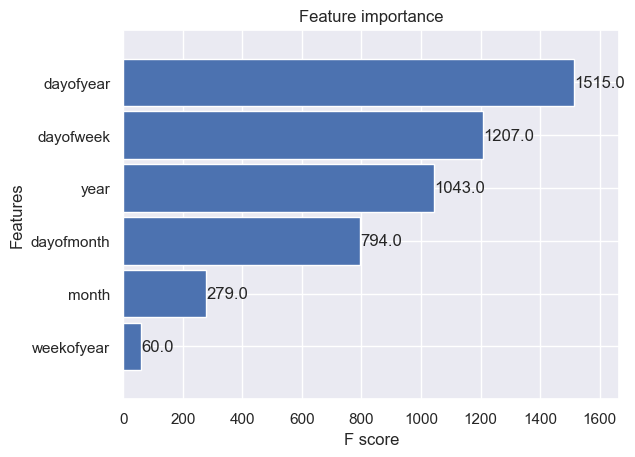

In [127]:
#plot feature importance
plot_importance(reg_tuned, height=0.9)

In [128]:
#plotting test and predictions
plot_test_predictions(y_test_df['total_amount'], predictions_xgb_tuned)

In [129]:
plot_forecast(y_train_df['total_amount'], y_test_df['total_amount'], xgboost_forecast_df['Forecast'])

# 4. LSTM Model
Chúng ta có thể sử dụng LSTM đơn biến để dự đoán giá trị tiếp theo trong chuỗi thời gian. Chúng tôi sẽ chỉ sử dụng dự đoán một bước, nghĩa là chúng tôi sẽ chỉ sử dụng một quan sát trước đó để dự đoán giá trị tiếp theo. 

Giống như các mẫu SARIMA, FB Prophet và XG Boost trước đây, LSTM cũng nhận đầu vào ở định dạng nhất định. Nó lấy một chuỗi dữ liệu với số lượng quan sát X số dấu thời gian X số lượng tính năng.

## 4.1. Preparing data for LSTM
Chúng ta cần Scale nó

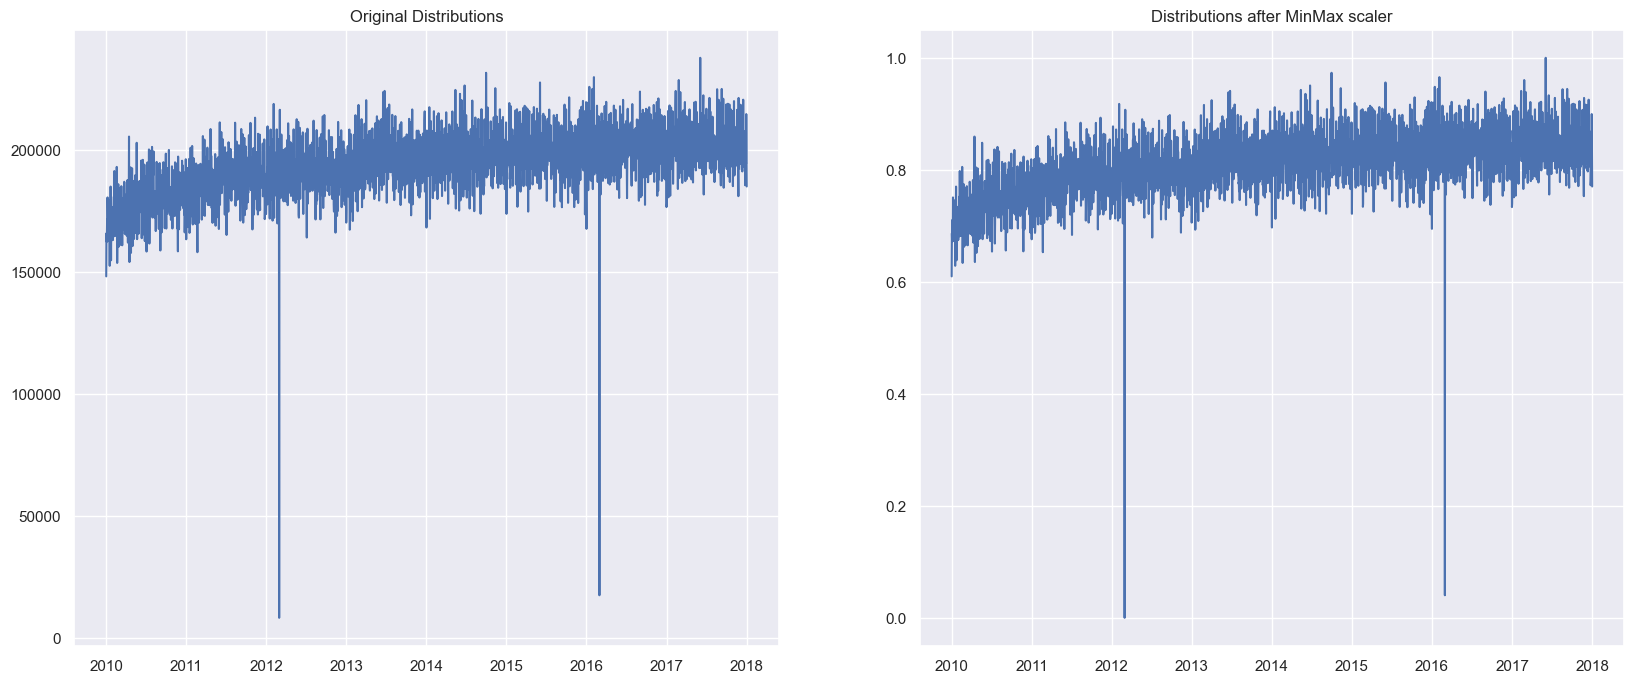

In [130]:
#scaling the date
sc = MinMaxScaler(feature_range = (0,1))
training_scaled = sc.fit_transform(train_df)
test_scaled = sc.transform(test_df)
fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
ax0.set_title('Original Distributions')
ax1.set_title('Distributions after MinMax scaler')
ax0.plot(train_df['total_amount'])
ax1.plot(pd.DataFrame(training_scaled,columns=['total_amount'], index=train_df.index)['total_amount'])

In [131]:
#define the lookback function for creating y

def lookback(df, window):
    X = list()
    Y = list()

    for i in range(window,len(df)):
        X.append(df[i-window:i, 0])
        Y.append(df[i,0])
    
    X,Y = np.array(X),np.array(Y)
    return X, Y

In [132]:
#creating X and y using lookback function
X_train_lstm, y_train_lstm = lookback(training_scaled, 1)
X_test_lstm, y_test_lstm = lookback(test_scaled, 1)

In [133]:
#checking shape of X
X_train_lstm.shape

(2922, 1)

In [134]:
#reshaping X for LSTM
#number of observations, timesteps and features
X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0],X_train_lstm.shape[1],1))
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0],X_test_lstm.shape[1],1))

In [135]:
X_train_lstm.shape

(2922, 1, 1)

## 4.2 Baseline model
Chúng ta hãy áp dụng mô hình LSM với ba lớp. Lớp bắt đầu có 100 nút, lớp thứ hai có 50 nút và lớp ngoài có 1 nút. Chúng tôi sẽ sử dụng chức năng dừng sớm của Keras để ngăn nó trang bị quá mức. Chúng tôi cũng đã chọn cỡ lô bằng 1


In [144]:
# random seeds for reproducibility
np.random.seed(123)
tf.random.set_seed(123)

model = Sequential()
# The input of LSTM layer has a shape of (num_timesteps, num_features)
model.add(LSTM(100, return_sequences=True, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu' ))
model.add(Dropout(0.2))
          
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

history = model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=16, shuffle=False,
                    validation_data=(X_test_lstm, y_test_lstm), verbose=1,
                    callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 1, 100)         │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3014 - val_loss: 0.0029
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108 - val_loss: 0.0034
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0102 - val_loss: 0.0029
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0095 - val_loss: 0.0029
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0092 - val_loss: 0.0031
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091 - val_loss: 0.0034
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0083 - val_loss: 0.0032
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079 - val_loss: 0.0034
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 - val_loss: 0.0035
Epoch 10/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071 - val_loss: 0.0034


In [145]:
#calaculating predictions
prediction_lstm = model.predict(X_test_lstm)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [146]:
#predicting and inversing the predictions to original time scale.

prediction_inverse = sc.inverse_transform(prediction_lstm.reshape(-1, 1))
y_test_inverse = sc.inverse_transform(y_test_lstm.reshape(-1, 1))

prediction2_inverse = np.array(prediction_inverse[:,0][1:])
y_test2_inverse = np.array(y_test_inverse[:,0])

In [147]:
#Evaluating the LSTM model.

y_test2_inverse_without_last = y_test2_inverse[:-1]
rmse_lstm = rmse(y_test2_inverse_without_last, prediction2_inverse)
mape_lstm = mape(y_test2_inverse_without_last, prediction2_inverse)
print(f"Root Mean Squared Error | RMSE: {rmse_lstm}")
print(f"Mean Absolute Percentage Error | MAPE: {mape_lstm}")

Root Mean Squared Error | RMSE: 11532.58
Mean Absolute Percentage Error | MAPE: 3.58


In [148]:
epochs = range(1, len(history.history["loss"]) + 1)


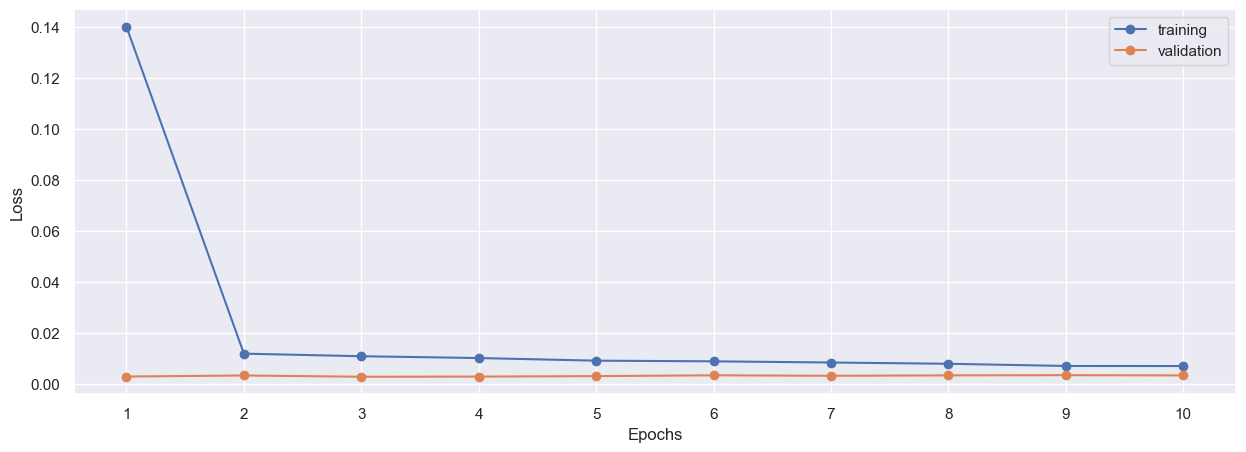

In [149]:
#plotting performance of the model
epochs = range(1, len(history.history["loss"]) + 1)

plt.figure(figsize=(15, 5))
plt.plot(epochs, history.history["loss"], label="training", marker="o")
plt.plot(epochs, history.history["val_loss"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.legend()
plt.show()

In [150]:
test_df[: -2].index
y_test2_inverse_without_last=pd.DataFrame(y_test2_inverse_without_last, columns=['total_amount'], index= test_df[: -2].index)

In [151]:
plot_test_predictions(y_test2_inverse_without_last['total_amount'], prediction2_inverse )

## 4.3. Tunning LSTM Model

In [157]:
# Define the grid search parameters
units_1 = [50, 100]
units_2 = [25, 50]
dropout_rates = [0.1, 0.2]
batch_sizes = [16, 32]
epochs = 10

# DataFrame to store results
LSTM_summary = pd.DataFrame(columns=['units_1', 'units_2', 'dropout_rate', 'batch_size', 'MAPE', 'RMSE'])

# Grid search
for u1 in units_1:
    for u2 in units_2:
        for dr in dropout_rates:
            for bs in batch_sizes:
                # Build LSTM model
                model = Sequential()
                model.add(LSTM(u1, return_sequences=True, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
                model.add(Dropout(dr))
                model.add(LSTM(u2, activation='relu'))
                model.add(Dropout(dr))
                model.add(Dense(1))
                
                model.compile(loss='mean_squared_error', optimizer='adam')

                # Fit the model
                history = model.fit(X_train_lstm, y_train_lstm, epochs=epochs, batch_size=bs, shuffle=False,
                                    validation_data=(X_test_lstm, y_test_lstm), verbose=0,
                                    callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=0)])

                # Make predictions
                prediction_lstm = model.predict(X_test_lstm)
                prediction_inverse = sc.inverse_transform(prediction_lstm.reshape(-1, 1))
                y_test_inverse = sc.inverse_transform(y_test_lstm.reshape(-1, 1))
                prediction2_inverse = np.array(prediction_inverse[:,0][1:])
                y_test2_inverse = np.array(y_test_inverse[:,0])
                y_test2_inverse_without_last = y_test2_inverse[:-1]

                # Calculate metrics
                rmse_lstm = rmse(y_test2_inverse_without_last, prediction2_inverse)
                mape_lstm = mape(y_test2_inverse_without_last, prediction2_inverse) 
                
                # Store results
                data_param = {
                    'units_1': u1,
                    'units_2': u2,
                    'dropout_rate': dr,
                    'batch_size': bs,
                    'MAPE': mape_lstm,
                    'RMSE': rmse_lstm
                }
                
                LSTM_summary = pd.concat([LSTM_summary, pd.DataFrame(data_param, columns=LSTM_summary.columns, index=[0])], ignore_index=True)

# Display summary
LSTM_summary.sort_values(by='MAPE', ascending=True)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


,units_1,units_2,dropout_rate,batch_size,MAPE,RMSE
9,100,25,0.1,32,2.23,7108.74
1,50,25,0.1,32,2.47,7870.36
15,100,50,0.2,32,2.62,8369.01
5,50,50,0.1,32,2.83,8808.34
13,100,50,0.1,32,3.00,9157.92
7,50,50,0.2,32,3.14,10005.77
8,100,25,0.1,16,3.14,9941.40
12,100,50,0.1,16,3.14,9751.64
0,50,25,0.1,16,3.22,10193.93
11,100,25,0.2,32,3.27,9697.97


In [158]:
# random seeds for reproducibility
np.random.seed(123)
tf.random.set_seed(123)

model = Sequential()
# The input of LSTM layer has a shape of (num_timesteps, num_features)
model.add(LSTM(100, return_sequences=True, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dropout(0.1))

model.add(LSTM(25, activation='relu' ))
model.add(Dropout(0.1))
          
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

history = model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, shuffle=False,
                    validation_data=(X_test_lstm, y_test_lstm), verbose=1,
                    callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)])

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_40 (LSTM)                  │ (None, 1, 100)         │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 1, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 25)             │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,426 (208.70 KB)

 Trainable params: 53,426 (208.70 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4533 - val_loss: 0.0060
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111 - val_loss: 0.0027
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083 - val_loss: 0.0031
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077 - val_loss: 0.0026
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082 - val_loss: 0.0027
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081 - val_loss: 0.0027
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 - val_loss: 0.0026
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 - val_loss: 0.0026
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078 - val_loss: 0.0029
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 - val_loss: 0.0026


In [159]:
#calaculating predictions
prediction_lstm = model.predict(X_test_lstm)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [160]:
#predicting and inversing the predictions to original time scale.

prediction_inverse = sc.inverse_transform(prediction_lstm.reshape(-1, 1))
y_test_inverse = sc.inverse_transform(y_test_lstm.reshape(-1, 1))

prediction2_inverse = np.array(prediction_inverse[:,0][1:])
y_test2_inverse = np.array(y_test_inverse[:,0])

In [161]:
#Evaluating the LSTM model.

y_test2_inverse_without_last = y_test2_inverse[:-1]
rmse_lstm = rmse(y_test2_inverse_without_last, prediction2_inverse)
mape_lstm = mape(y_test2_inverse_without_last, prediction2_inverse)
print(f"Root Mean Squared Error | RMSE: {rmse_lstm}")
print(f"Mean Absolute Percentage Error | MAPE: {mape_lstm}")

Root Mean Squared Error | RMSE: 6606.27
Mean Absolute Percentage Error | MAPE: 2.13


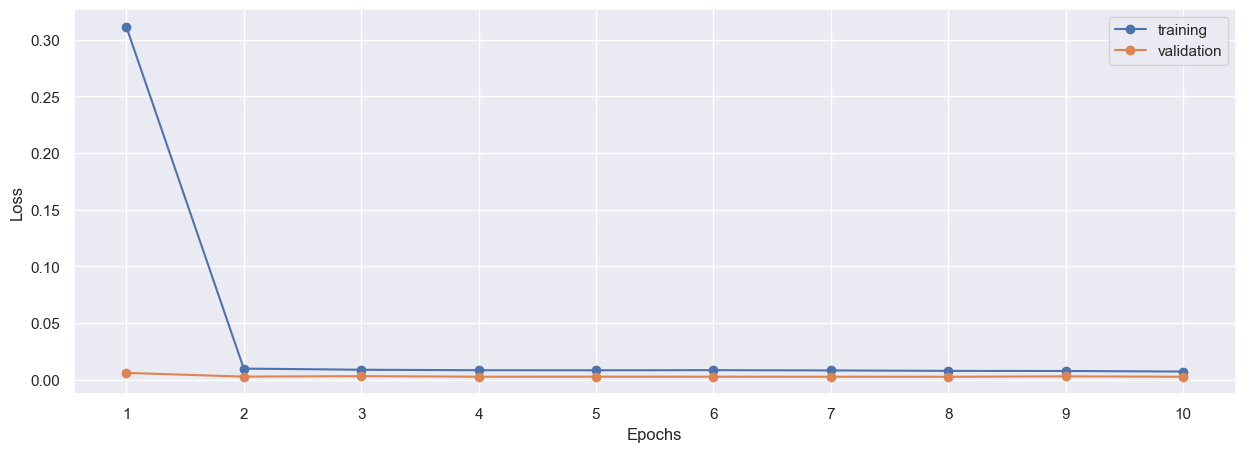

In [162]:
epochs = range(1, len(history.history["loss"]) + 1)

#plotting performance of the model
epochs = range(1, len(history.history["loss"]) + 1)

plt.figure(figsize=(15, 5))
plt.plot(epochs, history.history["loss"], label="training", marker="o")
plt.plot(epochs, history.history["val_loss"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.legend()
plt.show()

In [163]:
test_df[: -2].index
y_test2_inverse_without_last=pd.DataFrame(y_test2_inverse_without_last, columns=['total_amount'], index= test_df[: -2].index)

In [164]:
plot_test_predictions(y_test2_inverse_without_last['total_amount'], prediction2_inverse )